# Plot paper Fig 3: ASC coordinate system transformation

See `Calc_ASCcoord_transform_ocean.ipynb` and `Select_transets_630m_2000m.ipynb` for a description of the code used in this script. 

This script creates paper Fig 3: overview of the chosen cross-slope transects which make up a new ASC coordinate system.

### First, load in python modules

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

# Optional modules
import cmocean as cm
import xarray.ufuncs as xu
import matplotlib.path as mpath
import cartopy.crs as ccrs
import xgcm
import matplotlib.colors as colors
from scipy.interpolate import griddata

# For metpy function
# (use the conda3 unstable kernel)
from metpy.interpolate import cross_section
#from metpy.interpolate import interpolate_to_slice

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores

In [2]:
client = Client() # n_workers=4
client

distributed.diskutils - INFO - Found stale lock file and directory '/local/m68/wgh581/tmp/dask-worker-space/worker-o6jxef1i', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/m68/wgh581/tmp/dask-worker-space/worker-e4hoadr6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/m68/wgh581/tmp/dask-worker-space/worker-r9e6_w7_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/local/m68/wgh581/tmp/dask-worker-space/worker-thzp8u12', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43421,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.160:33473,Total threads: 4
Dashboard: /proxy/45147/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:39433,


Nominate a database from wich to load the data and define an experiment

In [3]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

### Load data

In [4]:
lat_slice = slice(-80, -58)

start_time = '2086-01-01'
end_time   = '2086-01-02'#'2086-12-31'

Load transect information calculated in `Calc_continental_slope_transects.ipynb`

In [5]:
out_path = '/g/data/x77/wgh581/Post_Process/'
#infile = out_path + 'Antarctic_slope_transects.npz'
infile = out_path + 'Antarctic_slope_transects_630m_2000m.npz'
data = np.load(infile)
lat_shelf = data['lat_630m']
lon_shelf = data['lon_630m']
lat_deep  = data['lat_2000m']
lon_deep  = data['lon_2000m']

Load bathymetry

In [6]:
# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)  
hu = hu.load()

# lat/lon information
xu_ocean = hu.xu_ocean.values
yu_ocean = hu.yu_ocean.values

Load velocity

In [7]:
# One day to test
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean_daily_3d_u_%.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice) 
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, ncfile="ocean_daily_3d_v_%.nc")
v = v.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)

In [8]:
u = u[0,:,:,:]
v = v[0,:,:,:]

Along-slope velocity

In [9]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [10]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Calculate the magnitude of the topographic slope
slope = xu.sqrt(dhu_dx**2 + dhu_dy**2)

In [11]:
# Along-slope velocity
u_along = u*dhu_dy/slope - v*dhu_dx/slope
u_along = u_along.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Prepare data to interpolate to cross-section

In [12]:
# Create dataset
ds = xr.Dataset({"u_along": u_along, "lat": u_along.yu_ocean, "lon": u_along.xu_ocean, "hu": hu})
# Rename coordinate names
ds = ds.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds['x'] = ds['x']+100
ds['x'].attrs = u_along['xu_ocean'].attrs
# MetPy parsing
u_parsed = ds.metpy.parse_cf('u_along', coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [13]:
ds_hu = xr.Dataset({"hu": hu})
ds_hu = ds_hu.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
ds_hu['x'] = ds_hu['x']+100
ds_hu['x'].attrs = hu['xu_ocean'].attrs
# Assgin CF-conforming grid mapping variable

#ds_hu = ds_hu.assign_attrs({'units':'m'})
hu_parsed  = ds_hu.metpy.parse_cf('hu', coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


### Check for monotonicity in bathymetry for each transect

In [14]:
# Helper function to get information about if we want to add or subtract a small increment to avoid duplication of the exact same value.
def get_increment_info(hu_raw):
    sign_info = np.sign(np.diff(hu_raw))
    add_increment = np.zeros(len(hu_raw))
    for mm in range(len(sign_info)):
        if sign_info[mm] == 0:
            # We have a duplicate, change add_info to something != 0
            if mm == 0:
                add_increment[mm+1] = 1
            else:
                if sign_info[mm-1] > 0:
                    add_increment[mm+1] = 1
                elif sign_info[mm-1] < 0:
                    add_increment[mm+1] = -1
                elif sign_info[mm-1] == 0:
                    add_increment[mm+1] = add_increment[mm]
    return add_increment

In [15]:
# Helper function for finding local minima/maxima
def get_local_min_max(hu_raw):
    b = (np.diff(np.sign(np.diff(hu_raw))) > 0).nonzero()[0] + 1 # local minimum
    c = (np.diff(np.sign(np.diff(hu_raw))) < 0).nonzero()[0] + 1 # local maximum
    b = b.tolist()
    c = c.tolist()
    return b, c

In [16]:
#%%time
count = 0
# Define various variables used below when looping through each transect.

max_depth = 2150#2010 # (st_ocean value deeper than target depth of 2000 m)
min_depth = 500#620  # (st_ocean value shallower than target depth of 650 m)
step_no   = 50   # Number of points on the transect that we interpolate the model grid onto

count_index_too_deep = []
count_index_ready    = []
count_index_smoothed = []
count_index_big      = []
delta_h_index_big    = []
count_index_small    = []
delta_h_index_small  = []
index_skipped_head_tail = []
count_index_tail     = []
count_index_head     = []
count_index_empty    = []

#binned_product = np.ones((len(lat_shelf), len(depth_avail), len(depth_bins_double))) * 1e6
ii_val = []
for ii in range(len(lat_shelf)):
    # Looping through each transect
    #if (ii > 2600) and (ii <= 3000):
    #if ii == 3100:
    if ii >= 0:
        ii_val.append(ii)
        # 1 - Interpolate model grid bathymetry onto cross-slope transect, use method='nearest'
        hu_raw = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
        hu_raw = hu_raw.values
        hu_raw_orig = hu_raw.copy() # Making a copy to compare changes to original data
        # Also interpolate the velocity onto the cross-slope transects, use method='nearest'
        #u_raw = cross_section(u_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')

        # 2 - Skip head/tail
        # Set all values deeper than max_depth to the last value (skip tail)
        if np.any(hu_raw > max_depth) == True:
            index_max_depth = np.argwhere(hu_raw > max_depth)[0][0]
            hu_raw = hu_raw[:index_max_depth]
            #u_raw  = u_raw[:,:index_max_depth]
            # Write out for which transects we cut the tail
            count_index_tail.append(ii)
        # Set all values shallower than min_depth to the next value (skip head)
        if np.any(hu_raw < min_depth) == True:
            index_min_depth = np.argwhere(hu_raw < min_depth)[-1][0]
            hu_raw = hu_raw[index_min_depth+1:]
            #u_raw  = u_raw[:,index_min_depth+1:]
            # Write out for which transects we cut the head
            count_index_head.append(ii)

        if len(hu_raw) == 0:
            print('hu_raw was empty after skipping head/tail for index ', ii)
            #binned_product[ii,:,:] = np.nan
            count_index_empty.append()
            continue
            
        # 3 - Ignore transects where the first value is too deep (some transects have nan at the beginning, get rid of the nans first)
        if np.isnan(hu_raw[0]) == True:
            #u_raw  = u_raw[:,~np.isnan(hu_raw)]
            hu_raw = hu_raw[~np.isnan(hu_raw)]
            if len(hu_raw) == 0:
                count_index_too_deep.append(ii)
                #binned_product[ii,:,:] = np.nan
                continue
        if (hu_raw[0] > 1200):
            count_index_too_deep.append(ii)
            #binned_product[ii,:,:] = np.nan
            continue
        
        # 4 - Check the first time for monotonicity. If so, hu_raw is ready to be used for the depth binning process. 
        # The only thing we need to do is to get rid of duplicates.
        if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
            # Write out which transects didn't need any smoothing, flattening, etc...
            count_index_ready.append(ii)
            # Get rid of any duplicates to make sure hu_raw is monotonically increasing:
            if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                # Find that index
                index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                for ll in range(np.size(index_duplicate[0])):
                    index = index_duplicate[0][ll] + 1
                    var   = hu_raw[index]
                    hu_raw[index] = var + 0.001 * (ll+1)
                del index_duplicate, index, var

        else:
            # 5 - Smoothing of small variability
            increment = 30 # in meter, smaller than the smallest change in the depth bins used later
            if np.any( np.abs(np.diff(hu_raw)) < increment) == True:
                # Find that index
                index_duplicate = np.where( np.abs(np.diff(hu_raw)) < increment)
                for ll in range(np.size(index_duplicate[0])):
                    index = index_duplicate[0][ll] + 1
                    var = hu_raw[index-1]
                    hu_raw[index] = var
                del index_duplicate, index, var

            # Again, make sure that no value is duplicated. This is to make it easier to select local minima and local maxima. 
            # This code differes slightly from the code above and below to change get rid of duplications, 
            # because here, we need hu_raw to increase and decrese depending on which side of a potentially existing bump we are.
            add_increment = get_increment_info(hu_raw)
            for ll in range(len(add_increment)):
                var = hu_raw[ll]
                if add_increment[ll] > 0:
                    hu_raw[ll] = var + (0.001*ll)
                elif add_increment[ll] < 0:
                    hu_raw[ll] = var - (0.001*ll)
            del add_increment, var
            
            # Check if smoothing alone helped to achieve monotonicity   
            if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
                # Write out which transects fall into this category
                count_index_smoothed.append(ii)
                if np.all( np.sign(np.diff(hu_raw)) == 0) == True:
                    print('Index %i still has duplicates, this needs to be fixed!'%ii)
               
            else: 
                # 6 - The remaining transects should have a bump (in other words, b and c below shouldn't be both empty)
            
                # Sanity check for local minima and local maxima
                b, c = get_local_min_max(hu_raw)
                if (len(b)==0) and (len(c)==0):
                    print('Problem: b, c are zero for index ', ii)
                
                # Skip the tail if the local maximum is deeper than the last value
                if (len(c)>0):
                    index_tmp = np.argmax(hu_raw[c])
                    if hu_raw[c[index_tmp]] > hu_raw[-1]:
                        hu_raw = hu_raw[:c[index_tmp]+1]
                        #u_raw  = u_raw[:,:c[index_tmp]+1]
                        # Calculate local min/max again
                        b, c = get_local_min_max(hu_raw)
                    del index_tmp
                # Skip the head if the local minimum is shallower than the first value
                if (len(b)>0):
                    index_tmp = np.argmin(hu_raw[b])
                    if hu_raw[b[index_tmp]] < hu_raw[0]:
                        #print('entered loop')
                        hu_raw = hu_raw[b[index_tmp]:]
                        #u_raw  = u_raw[:,b[index_tmp]:]
                        b, c = get_local_min_max(hu_raw)
                    del index_tmp
                    
                # 7 - Now check for local minima and maxima
                if (len(b) == 0) and (len(c) == 0):
                    # Might exist if we skipped tail/head
                    index_skipped_head_tail.append(ii)
                    delta_h = None
                elif (len(b) == 1) and (len(c) == 1):
                    # Only one bump exists
                    index_delta_h = 0
                    delta_h = hu_raw[c[index_delta_h]] - hu_raw[b[index_delta_h]]
                elif (len(b) > 1) and (len(c) > 1):
                    # Multiple bumps exist, we are interested in the largest to classify the transect
                    index_length = np.min([len(b), len(c)])
                    delta_h = hu_raw[c[:index_length]] - hu_raw[b[:index_length]]
                    index_delta_h = np.argmax(delta_h)
                    delta_h = np.max(delta_h)
                    del index_length
                elif (len(b)==1) and (len(c)!=1):
                    print('Only one minimum left, index ', ii)
                    delta_h = None
                elif (len(b)!=1) and (len(c)==1):
                    print('Only one maximum left, index ', ii)
                    delta_h = None

                # Classify into small or large bump transects
                if delta_h != None:
                    # Only look at cases where we have bumps
                    if delta_h < 0:
                        # Sanity check for any negative delta_h. This would mean the local minimum and maximum used to calculate delta_h originates from different bumps
                        print('Negative delta for index ', ii)
                    elif delta_h > 200:
                        # 7.1 Big bumps
                        #binned_product[ii,:,:] = np.nan
                        count_index_big.append(ii)
                        delta_h_index_big.append(delta_h)
                        continue
                    elif (delta_h > 0) and (delta_h <= 200):
                        # 7.2 Small bumps
                        # Now, this is where the real joy begins...
                        count_index_small.append(ii)
                        delta_h_index_small.append(delta_h)
                        if hu_raw[c[index_delta_h]] == np.max(hu_raw):
                            # 7.2.1 Skip the tail if the local minimum is the deepest value. 
                            hu_raw = hu_raw[:c[index_delta_h]+1]
                            print('Case 5.3.1 for index ', ii)
                            del index_delta_h
                        else:
                            # 7.2.2 Flatten hu_raw for the remaining transects
                            # Find the depth of the first local maximum (a trough)
                            if len(b) != len(c):
                                print('Number of minima and maxima not equal for index ', ii)
                            else:
                                for mm in range(len(b)):
                                    hu_tmp = hu_raw[c[mm]]
                                    hu_tmp_next_index = np.argwhere(hu_raw[c[mm]:] > hu_tmp)[0][0]
                                    hu_raw[c[mm]:c[mm]+hu_tmp_next_index] = hu_raw[c[mm]]
                                    # Again, make sure bathymetry differs for each point
                                    if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                                        # Find that index
                                        index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                                        for ll in range(np.size(index_duplicate[0])):
                                            index = index_duplicate[0][ll] + 1
                                            var   = hu_raw[index]#.values
                                            hu_raw[index] = var + 0.001 * (ll+1)
                                        del index_duplicate, index, var

        # One last sanity check: hu_raw should (finally!) have a monotonic increase for all transects:
        if np.any(np.diff(hu_raw) < 0) == True:
            print('Last sanity check, problem with index ', ii) 
        # And if there are any duplicates
        if np.any(np.diff(hu_raw)) == 0:
            print('Last sanity check, problem with duplicates for index ', ii)

print('Number of transects where I cut the tail: ', len(count_index_tail))
print('Number of transects where I cut the head: ', len(count_index_head))
print('Number of transects that are empty after cutting head/tail: ', len(count_index_empty))
print('Number of transects that do not need any changes: ', len(count_index_ready))
print('Number of transects that do not need any changes after smoothing: ', len(count_index_smoothed))
print('Number of transects with a bump larger than 200 m: ', len(count_index_big))
print('Number of transects with a bump smaller than 200 m: ', len(count_index_small))
print('Number of transects that have a too deep first value: ', len(count_index_too_deep))
print('Number of transects where we skipped the head/tail where there was a bump: ', len(index_skipped_head_tail))

Number of transects where I cut the tail:  2463
Number of transects where I cut the head:  1905
Number of transects that are empty after cutting head/tail:  0
Number of transects that do not need any changes:  2409
Number of transects that do not need any changes after smoothing:  322
Number of transects with a bump larger than 200 m:  121
Number of transects with a bump smaller than 200 m:  395
Number of transects that have a too deep first value:  126
Number of transects where we skipped the head/tail where there was a bump:  147


### Map of transects

In [17]:
# Data required for lat/lon mapping and bathymetry contours
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

Load shelf and deep contour information

In [18]:
def get_lat_lon_along_contour_plt_approach():
    file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_smoothed_u_t_630m_plt_approach.npz'
    data = np.load(file_path)
    #print(data.files)
    return data['lon_along_contour_u'], data['lat_along_contour_u'], data['num_points_u']

def get_lat_lon_along_contour(isobath_depth):
    file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_smoothed_' + str(isobath_depth) + 'm.npz'
    data = np.load(file_path)
    return data['lon_along_contour'], data['lat_along_contour'], data['num_points']

In [19]:
lon_630, lat_630, num_points_630 = get_lat_lon_along_contour_plt_approach()
lon_2000, lat_2000, num_points_2000 = get_lat_lon_along_contour(2000)

Plotting maps

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


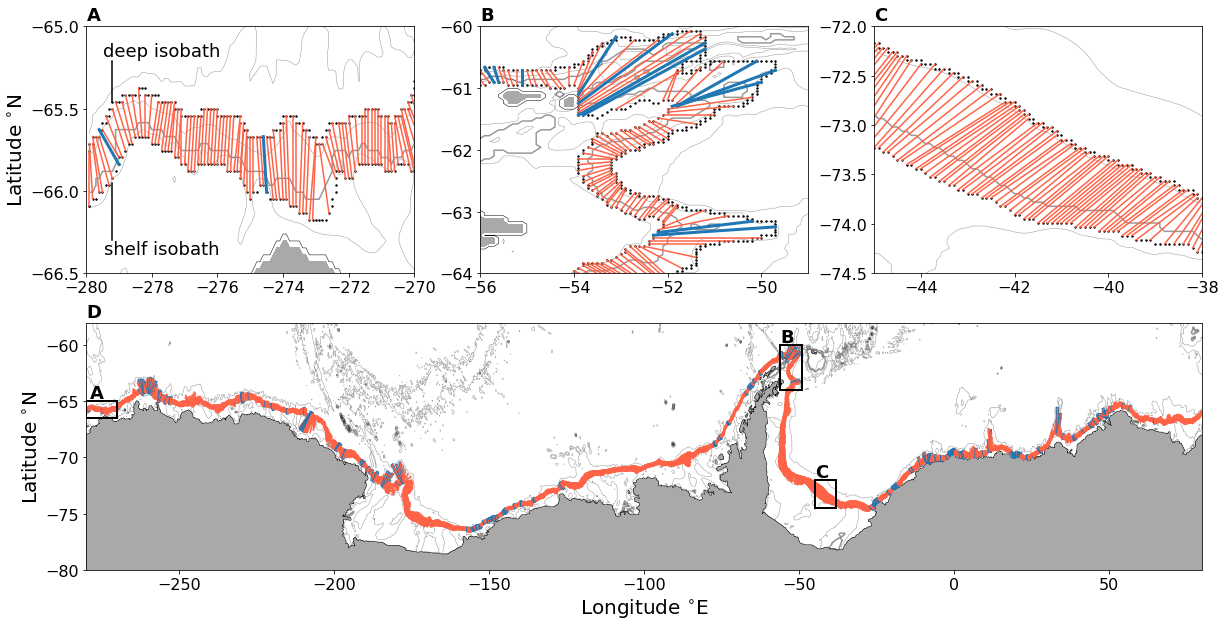

In [70]:
import matplotlib.gridspec as gridspec
ft_size = 18
lw = 2
fig_path = '/g/data/x77/wgh581/Figures/'
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

# 1000 m isobath
contour_1000m = hu.sel(yu_ocean = lat_slice)
contour_1000m = contour_1000m.where(contour_1000m > 1000)
contour_1000m = contour_1000m * 0 + 1
contour_1000m = contour_1000m.fillna(0)

fig = plt.figure(figsize=(20, 10))

# Define axes
gs   = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1], hspace=0.2, wspace=0.2)
#gs_1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[ii], hspace=0.02)
gs_1 = fig.add_subplot(gs[0,0])
gs_2 = fig.add_subplot(gs[0,1])
gs_3 = fig.add_subplot(gs[0,2])
gs_4 = fig.add_subplot(gs[1,:])

# Map with all transects (bottom)
gs_4.set_title(r'$\bf{D}$', fontsize=ft_size, loc='left')
# Plot land
gs_4.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_4.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_4.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_4.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
gs_4.set_ylim(-80, -58)
gs_4.set_xlim(-280, 80)
# Plot transects
for ii in range(len(lon_shelf)):
    # Highlight the transects that I ignore
    if ii in (count_index_big):
        # Big bump transects
        gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
    if ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3) 
    else:
        # All transects
        gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
gs_4.set_xlabel('Longitude $^{\circ}$E', fontsize=ft_size+2)
gs_4.set_ylabel('Latitude $^{\circ}$N', fontsize=ft_size+2)
# Add insert 1
gs_4.text(-279, -64.7, r'$\bf{A}$', fontsize=ft_size)
gs_4.plot([-280, -270], [-65, -65], color='k', linewidth=lw)
gs_4.plot([-280, -270], [-66.5, -66.5], color='k', linewidth=lw)
gs_4.plot([-280, -280], [-66.5, -65], color='k', linewidth=lw)
gs_4.plot([-270, -270], [-66.5, -65], color='k', linewidth=lw)
# Add insert 2
gs_4.text(-56, -59.7, r'$\bf{B}$', fontsize=ft_size)
gs_4.plot([-56, -49], [-60, -60], color='k', linewidth=lw)
gs_4.plot([-56, -49], [-64, -64], color='k', linewidth=lw)
gs_4.plot([-56, -56], [-64, -60], color='k', linewidth=lw)
gs_4.plot([-49, -49], [-64, -60], color='k', linewidth=lw)
# Add insert 3
gs_4.text(-45, -71.7, r'$\bf{C}$', fontsize=ft_size)
gs_4.plot([-45, -38], [-74.5, -74.5], color='k', linewidth=lw)
gs_4.plot([-45, -38], [-72, -72], color='k', linewidth=lw)
gs_4.plot([-45, -45], [-72, -74.5], color='k', linewidth=lw)
gs_4.plot([-38, -38], [-72, -74.5], color='k', linewidth=lw)
# Fontsize of ticks
gs_4.tick_params(axis="x", labelsize=ft_size-2)
gs_4.tick_params(axis="y", labelsize=ft_size-2)

# Insert 1
gs_1.set_title(r'$\bf{A}$', fontsize=ft_size, loc='left')
# Plot land
gs_1.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_1.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_1.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_1.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
# Plot transects
for ii in range(len(lon_shelf)):
    if ii in (count_index_big):
        # Big bump transects
        gs_1.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
    elif ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        gs_1.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3) 
    else:
        # All transects
        gs_1.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
# Add shelf and deep contour points
gs_1.scatter(lon_630, lat_630, color='k', s=2)
gs_1.scatter(lon_2000, lat_2000, color='k', s=2)
# Set boundaries
gs_1.set_xlim(-280, -270)
gs_1.set_ylim(-66.5, -65)
# Fontsize of ticks
gs_1.tick_params(axis="x", labelsize=ft_size-2)
gs_1.tick_params(axis="y", labelsize=ft_size-2)
gs_1.set_ylabel('Latitude $^{\circ}$N', fontsize=ft_size+2)
gs_1.set_yticks(np.arange(-66.5, -64.9, 0.5))
gs_1.text(-277.7, -66.35, "shelf isobath", ha="center", va="center", size=ft_size)#, bbox=bbox_props)
gs_1.text(-277.7, -65.15, "deep isobath", ha="center", va="center", size=ft_size)#, bbox=bbox_props)
gs_1.plot([-279.2, -279.2], [-66.3, -65.95], 'k')
gs_1.plot([-279.2, -279.2], [-65.46, -65.21], 'k')

# Insert 2
gs_2.set_title(r'$\bf{B}$', fontsize=ft_size, loc='left')
# Plot land
gs_2.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_2.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_2.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_2.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
# Plot transects
for ii in range(len(lon_shelf)):
    if ii in (count_index_big):
        # Big bump transects
        gs_2.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
    elif ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        gs_2.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3) 
    else:
        # All transects
        gs_2.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
# Add shelf and deep contour points
gs_2.scatter(lon_630, lat_630, color='k', s=2)
gs_2.scatter(lon_2000, lat_2000, color='k', s=2)
# Set boundaries
gs_2.set_xlim(-56, -49)
gs_2.set_ylim(-64, -60)
# Fontsize of ticks
gs_2.tick_params(axis="x", labelsize=ft_size-2)
gs_2.tick_params(axis="y", labelsize=ft_size-2)
gs_2.set_yticks(np.arange(-64, -59, 1))

# Insert 3
gs_3.set_title(r'$\bf{C}$', fontsize=ft_size, loc='left')
# Plot land
gs_3.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_3.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_3.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_3.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
# Plot transects
for ii in range(len(lon_shelf)):
    if ii in (count_index_big):
        # Big bump transects
        gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
    elif ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3) 
    else:
        # All transects
        gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
# Add shelf and deep contour points
gs_3.scatter(lon_630, lat_630, color='k', s=2)
gs_3.scatter(lon_2000, lat_2000, color='k', s=2)
# Set boundaries
gs_3.set_xlim(-45, -38)
gs_3.set_ylim(-74.5, -72)
# Fontsize of ticks
gs_3.tick_params(axis="x", labelsize=ft_size-2)
gs_3.tick_params(axis="y", labelsize=ft_size-2)
gs_3.set_yticks(np.arange(-74.5, -71.9, 0.5))


# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_binning_transects_examples.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

Checking aspect ratio (in panels it looks like the transects are not cross-slope=shortest distance, which they are)

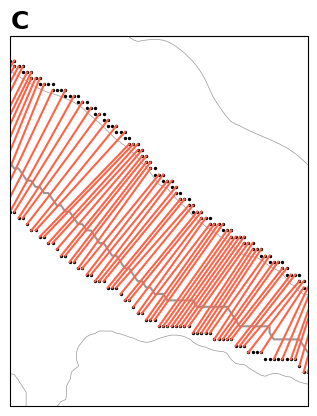

In [32]:
fig = plt.figure()

gs_3 = plt.subplot(111, projection=ccrs.Mercator(central_longitude=180))
# Insert 3
gs_3.set_title(r'$\bf{C}$', fontsize=ft_size, loc='left')
# Plot land
gs_3.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
gs_3.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
gs_3.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5, transform=ccrs.PlateCarree())
gs_3.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5, transform=ccrs.PlateCarree())
# Plot transects
for ii in range(len(lon_shelf)):
    if ii in (count_index_big):
        # Big bump transects
        gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3, transform=ccrs.PlateCarree())
    elif ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3, transform=ccrs.PlateCarree()) 
    else:
        # All transects
        gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato', transform=ccrs.PlateCarree())
gs_3.scatter(lon_630, lat_630, color='k', s=2, transform=ccrs.PlateCarree())
gs_3.scatter(lon_2000, lat_2000, color='k', s=2, transform=ccrs.PlateCarree())
gs_3.set_extent([-45, -38, -74.5, -72], crs=ccrs.PlateCarree())


In [23]:
import matplotlib.gridspec as gridspec
ft_size = 18
lw = 2
fig_path = '/g/data/x77/wgh581/Figures/'
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

# 1000 m isobath
contour_1000m = hu.sel(yu_ocean = lat_slice)
contour_1000m = contour_1000m.where(contour_1000m > 1000)
contour_1000m = contour_1000m * 0 + 1
contour_1000m = contour_1000m.fillna(0)

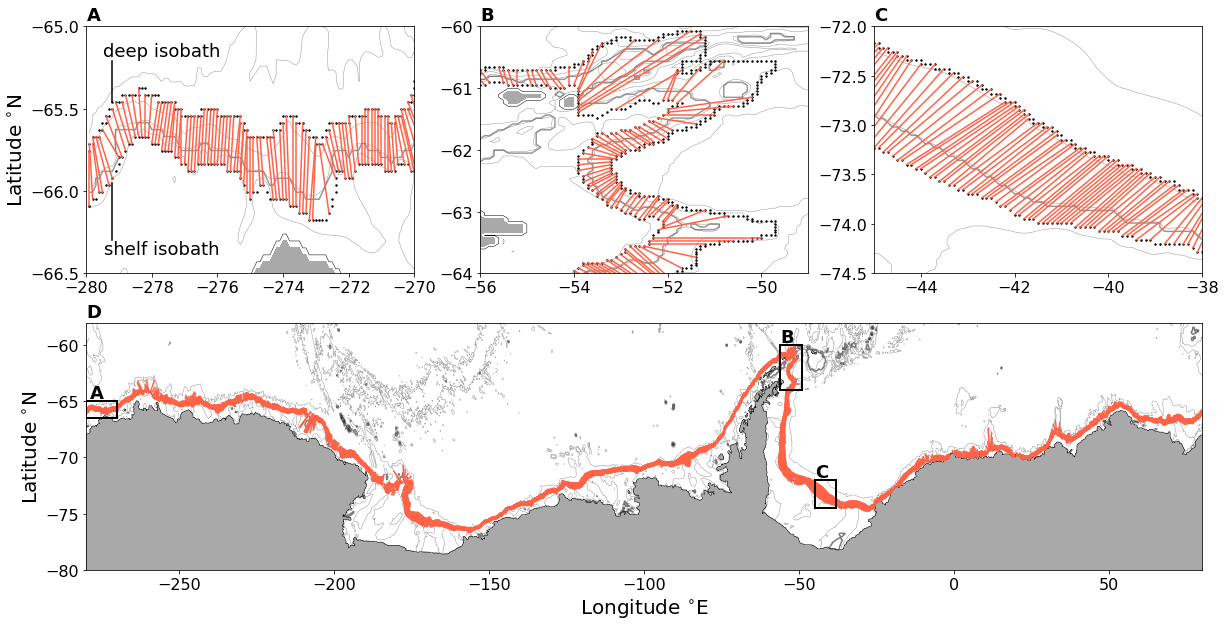

In [26]:
fig = plt.figure(figsize=(20, 10))

# Define axes
gs   = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1], hspace=0.2, wspace=0.2)
#gs_1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[ii], hspace=0.02)
gs_1 = fig.add_subplot(gs[0,0])
gs_2 = fig.add_subplot(gs[0,1])
gs_3 = fig.add_subplot(gs[0,2])
gs_4 = fig.add_subplot(gs[1,:])

# Map with all transects (bottom)
gs_4.set_title(r'$\bf{D}$', fontsize=ft_size, loc='left')
# Plot land
gs_4.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_4.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_4.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_4.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 1000, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
gs_4.set_ylim(-80, -58)
gs_4.set_xlim(-280, 80)
# Plot transects
for ii in range(len(lon_shelf)):
    # Don't show the transects that I ignore
    if ii in (count_index_big):
        # Big bump transects
        #gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
        continue
    if ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        #gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3) 
        continue
    else:
        # All transects
        gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
gs_4.set_xlabel('Longitude $^{\circ}$E', fontsize=ft_size+2)
gs_4.set_ylabel('Latitude $^{\circ}$N', fontsize=ft_size+2)
# Add insert 1
gs_4.text(-279, -64.7, r'$\bf{A}$', fontsize=ft_size)
gs_4.plot([-280, -270], [-65, -65], color='k', linewidth=lw)
gs_4.plot([-280, -270], [-66.5, -66.5], color='k', linewidth=lw)
gs_4.plot([-280, -280], [-66.5, -65], color='k', linewidth=lw)
gs_4.plot([-270, -270], [-66.5, -65], color='k', linewidth=lw)
# Add insert 2
gs_4.text(-56, -59.7, r'$\bf{B}$', fontsize=ft_size)
gs_4.plot([-56, -49], [-60, -60], color='k', linewidth=lw)
gs_4.plot([-56, -49], [-64, -64], color='k', linewidth=lw)
gs_4.plot([-56, -56], [-64, -60], color='k', linewidth=lw)
gs_4.plot([-49, -49], [-64, -60], color='k', linewidth=lw)
# Add insert 3
gs_4.text(-45, -71.7, r'$\bf{C}$', fontsize=ft_size)
gs_4.plot([-45, -38], [-74.5, -74.5], color='k', linewidth=lw)
gs_4.plot([-45, -38], [-72, -72], color='k', linewidth=lw)
gs_4.plot([-45, -45], [-72, -74.5], color='k', linewidth=lw)
gs_4.plot([-38, -38], [-72, -74.5], color='k', linewidth=lw)
# Fontsize of ticks
gs_4.tick_params(axis="x", labelsize=ft_size-2)
gs_4.tick_params(axis="y", labelsize=ft_size-2)

# Insert 1
gs_1.set_title(r'$\bf{A}$', fontsize=ft_size, loc='left')
# Plot land
gs_1.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_1.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_1.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_1.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 1000, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
# Plot transects
for ii in range(len(lon_shelf)):
    if ii in (count_index_big):
        # Big bump transects
        #gs_1.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
        continue
    elif ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        #gs_1.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3) 
        continue
    else:
        # All transects
        gs_1.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
# Add shelf and deep contour points
gs_1.scatter(lon_630, lat_630, color='k', s=2)
gs_1.scatter(lon_2000, lat_2000, color='k', s=2)
# Set boundaries
gs_1.set_xlim(-280, -270)
gs_1.set_ylim(-66.5, -65)
# Fontsize of ticks
gs_1.tick_params(axis="x", labelsize=ft_size-2)
gs_1.tick_params(axis="y", labelsize=ft_size-2)
gs_1.set_ylabel('Latitude $^{\circ}$N', fontsize=ft_size+2)
gs_1.set_yticks(np.arange(-66.5, -64.9, 0.5))
gs_1.text(-277.7, -66.35, "shelf isobath", ha="center", va="center", size=ft_size)#, bbox=bbox_props)
gs_1.text(-277.7, -65.15, "deep isobath", ha="center", va="center", size=ft_size)#, bbox=bbox_props)
gs_1.plot([-279.2, -279.2], [-66.3, -65.95], 'k')
gs_1.plot([-279.2, -279.2], [-65.46, -65.21], 'k')

# Insert 2
gs_2.set_title(r'$\bf{B}$', fontsize=ft_size, loc='left')
# Plot land
gs_2.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_2.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_2.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_2.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 1000, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
# Plot transects
for ii in range(len(lon_shelf)):
    if ii in (count_index_big):
        # Big bump transects
        #gs_2.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
        continue
    elif ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        #gs_2.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
        continue
    else:
        # All transects
        gs_2.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
# Add shelf and deep contour points
gs_2.scatter(lon_630, lat_630, color='k', s=2)
gs_2.scatter(lon_2000, lat_2000, color='k', s=2)
# Set boundaries
gs_2.set_xlim(-56, -49)
gs_2.set_ylim(-64, -60)
# Fontsize of ticks
gs_2.tick_params(axis="x", labelsize=ft_size-2)
gs_2.tick_params(axis="y", labelsize=ft_size-2)
gs_2.set_yticks(np.arange(-64, -59, 1))

# Insert 3
gs_3.set_title(r'$\bf{C}$', fontsize=ft_size, loc='left')
# Plot land
gs_3.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_3.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_3.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_3.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 1000, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
# Plot transects
for ii in range(len(lon_shelf)):
    if ii in (count_index_big):
        # Big bump transects
        #gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
        continue
    elif ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        #gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3) 
        continue
    else:
        # All transects
        gs_3.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
# Add shelf and deep contour points
gs_3.scatter(lon_630, lat_630, color='k', s=2)
gs_3.scatter(lon_2000, lat_2000, color='k', s=2)
# Set boundaries
gs_3.set_xlim(-45, -38)
gs_3.set_ylim(-74.5, -72)
# Fontsize of ticks
gs_3.tick_params(axis="x", labelsize=ft_size-2)
gs_3.tick_params(axis="y", labelsize=ft_size-2)
gs_3.set_yticks(np.arange(-74.5, -71.9, 0.5))


# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_binning_transects_examples_maintext.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

### Figure for appendix: examples for where bathymetry is not monotonic

In [20]:
# Pretty much the same code as above, but written as a function to call for specific transects that then can be plotted.

count = 0

max_depth = 2150#2010 # (st_ocean value deeper than target depth of 2000 m)
min_depth = 500#620  # (st_ocean value shallower than target depth of 650 m)
step_no   = 50   # Number of points on the transect that we interpolate the model grid onto

#for ii in range(len(lat_shelf)):
def get_hu_transects(value):
    # Looping through transect
    for ii in range(len(lat_shelf)):
        if ii == value:

            # 1 - Interpolate model grid bathymetry onto cross-slope transect, use method='nearest'
            hu_raw = cross_section(hu_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')
            hu_raw = hu_raw.values
            hu_raw_orig = hu_raw.copy() # Making a copy to compare changes to original data
            # Also interpolate the velocity onto the cross-slope transects, use method='nearest'
            #u_raw = cross_section(u_parsed, start=(lat_shelf[ii], lon_shelf[ii]+100), end=(lat_deep[ii], lon_deep[ii]+100), steps=step_no, interp_type='nearest')

            # 2 - Skip head/tail
            # Set all values deeper than max_depth to the last value (skip tail)
            if np.any(hu_raw > max_depth) == True:
                index_max_depth = np.argwhere(hu_raw > max_depth)[0][0]
                hu_raw = hu_raw[:index_max_depth]
                #u_raw  = u_raw[:,:index_max_depth]
                # Write out for which transects we cut the tail
                #count_index_tail.append(ii)
            # Set all values shallower than min_depth to the next value (skip head)
            if np.any(hu_raw < min_depth) == True:
                index_min_depth = np.argwhere(hu_raw < min_depth)[-1][0]
                hu_raw = hu_raw[index_min_depth+1:]
                #u_raw  = u_raw[:,index_min_depth+1:]
                # Write out for which transects we cut the head
                #count_index_head.append(ii)

            if len(hu_raw) == 0:
                print('hu_raw was empty after skipping head/tail for index ', ii)
                #binned_product[ii,:,:] = np.nan
                #count_index_empty.append()
                continue

            # 3 - Ignore transects where the first value is too deep (some transects have nan at the beginning, get rid of the nans first)
            if np.isnan(hu_raw[0]) == True:
                #u_raw  = u_raw[:,~np.isnan(hu_raw)]
                hu_raw = hu_raw[~np.isnan(hu_raw)]
                index = ii
                if len(hu_raw) == 0:
                    #count_index_too_deep.append(ii)
                    #binned_product[ii,:,:] = np.nan
                    continue
            if (hu_raw[0] > 1200):
                #count_index_too_deep.append(ii)
                #binned_product[ii,:,:] = np.nan
                continue

            # 4 - Check the first time for monotonicity. If so, hu_raw is ready to be used for the depth binning process. 
            # The only thing we need to do is to get rid of duplicates.
            if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
                # Write out which transects didn't need any smoothing, flattening, etc...
                #count_index_ready.append(ii)
                # Get rid of any duplicates to make sure hu_raw is monotonically increasing:
                if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                    # Find that index
                    index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                    for ll in range(np.size(index_duplicate[0])):
                        index = index_duplicate[0][ll] + 1
                        var   = hu_raw[index]
                        hu_raw[index] = var + 0.001 * (ll+1)
                    del index_duplicate, index, var

            else:
                # 5 - Smoothing of small variability
                increment = 30 # in meter, smaller than the smallest change in the depth bins used later
                if np.any( np.abs(np.diff(hu_raw)) < increment) == True:
                    # Find that index
                    index_duplicate = np.where( np.abs(np.diff(hu_raw)) < increment)
                    for ll in range(np.size(index_duplicate[0])):
                        index = index_duplicate[0][ll] + 1
                        var = hu_raw[index-1]
                        hu_raw[index] = var
                    del index_duplicate, index, var

                # Again, make sure that no value is duplicated. This is to make it easier to select local minima and local maxima. 
                # This code differes slightly from the code above and below to change get rid of duplications, 
                # because here, we need hu_raw to increase and decrese depending on which side of a potentially existing bump we are.
                add_increment = get_increment_info(hu_raw)
                for ll in range(len(add_increment)):
                    var = hu_raw[ll]
                    if add_increment[ll] > 0:
                        hu_raw[ll] = var + (0.001*ll)
                    elif add_increment[ll] < 0:
                        hu_raw[ll] = var - (0.001*ll)
                del add_increment, var

                # Check if smoothing alone helped to achieve monotonicity   
                if np.all( np.sign(np.diff(hu_raw)) >= 0) == True:
                    # Write out which transects fall into this category
                    #count_index_smoothed.append(ii)
                    if np.all( np.sign(np.diff(hu_raw)) == 0) == True:
                        print('Index %i still has duplicates, this needs to be fixed!'%ii)

                else: 
                    # 6 - The remaining transects should have a bump (in other words, b and c below shouldn't be both empty)

                    # Sanity check for local minima and local maxima
                    b, c = get_local_min_max(hu_raw)
                    if (len(b)==0) and (len(c)==0):
                        print('Problem: b, c are zero for index ', ii)

                    # Skip the tail if the local maximum is deeper than the last value
                    if (len(c)>0):
                        index_tmp = np.argmax(hu_raw[c])
                        if hu_raw[c[index_tmp]] > hu_raw[-1]:
                            hu_raw = hu_raw[:c[index_tmp]+1]
                            #u_raw  = u_raw[:,:c[index_tmp]+1]
                            # Calculate local min/max again
                            b, c = get_local_min_max(hu_raw)
                        del index_tmp
                    # Skip the head if the local minimum is shallower than the first value
                    if (len(b)>0):
                        index_tmp = np.argmin(hu_raw[b])
                        if hu_raw[b[index_tmp]] < hu_raw[0]:
                            #print('entered loop')
                            hu_raw = hu_raw[b[index_tmp]:]
                            #u_raw  = u_raw[:,b[index_tmp]:]
                            b, c = get_local_min_max(hu_raw)
                        del index_tmp

                    # 7 - Now check for local minima and maxima
                    if (len(b) == 0) and (len(c) == 0):
                        # Might exist if we skipped tail/head
                        #index_skipped_head_tail.append(ii)
                        delta_h = None
                    elif (len(b) == 1) and (len(c) == 1):
                        # Only one bump exists
                        index_delta_h = 0
                        delta_h = hu_raw[c[index_delta_h]] - hu_raw[b[index_delta_h]]
                    elif (len(b) > 1) and (len(c) > 1):
                        # Multiple bumps exist, we are interested in the largest to classify the transect
                        index_length = np.min([len(b), len(c)])
                        delta_h = hu_raw[c[:index_length]] - hu_raw[b[:index_length]]
                        index_delta_h = np.argmax(delta_h)
                        delta_h = np.max(delta_h)
                        del index_length
                    elif (len(b)==1) and (len(c)!=1):
                        print('Only one minimum left, index ', ii)
                        delta_h = None
                    elif (len(b)!=1) and (len(c)==1):
                        print('Only one maximum left, index ', ii)
                        delta_h = None

                    # Classify into small or large bump transects
                    if delta_h != None:
                        # Only look at cases where we have bumps
                        if delta_h < 0:
                            # Sanity check for any negative delta_h. This would mean the local minimum and maximum used to calculate delta_h originates from different bumps
                            print('Negative delta for index ', ii)
                        elif delta_h > 200:
                            # 7.1 Big bumps
                            #binned_product[ii,:,:] = np.nan
                            #count_index_big.append(ii)
                            #delta_h_index_big.append(delta_h)
                            continue
                        elif (delta_h > 0) and (delta_h <= 200):
                            # 7.2 Small bumps
                            # Now, this is where the real joy begins...
                            #count_index_small.append(ii)
                            #delta_h_index_small.append(delta_h)
                            if hu_raw[c[index_delta_h]] == np.max(hu_raw):
                                # 7.2.1 Skip the tail if the local minimum is the deepest value. 
                                hu_raw = hu_raw[:c[index_delta_h]+1]
                                print('Case 5.3.1 for index ', ii)
                                del index_delta_h
                            else:
                                # 7.2.2 Flatten hu_raw for the remaining transects
                                # Find the depth of the first local maximum (a trough)
                                if len(b) != len(c):
                                    print('Number of minima and maxima not equal for index ', ii)
                                else:
                                    for mm in range(len(b)):
                                        hu_tmp = hu_raw[c[mm]]
                                        hu_tmp_next_index = np.argwhere(hu_raw[c[mm]:] > hu_tmp)[0][0]
                                        hu_raw[c[mm]:c[mm]+hu_tmp_next_index] = hu_raw[c[mm]]
                                        # Again, make sure bathymetry differs for each point
                                        if np.any( np.abs(np.diff(hu_raw)) < 1e-5) == True:
                                            # Find that index
                                            index_duplicate = np.where( np.abs(np.diff(hu_raw)) < 1e-5)
                                            for ll in range(np.size(index_duplicate[0])):
                                                index = index_duplicate[0][ll] + 1
                                                var   = hu_raw[index]#.values
                                                hu_raw[index] = var + 0.001 * (ll+1)
                                            del index_duplicate, index, var

            # One last sanity check: hu_raw should (finally!) have a monotonic increase for all transects:
            if np.any(np.diff(hu_raw) < 0) == True:
                print('Last sanity check, problem with index ', ii) 
            # And if there are any duplicates
            if np.any(np.diff(hu_raw)) == 0:
                print('Last sanity check, problem with duplicates for index ', ii)
                   
    return hu_raw, hu_raw_orig


In [49]:
import matplotlib.gridspec as gridspec
panel_names = ['A', 'B', 'C']
panel_title = ['Smoothed', 'Flattened', 'Deleted']
bump_name   = [r'undulations $\leq$ 30 m', r'30 m < undulations $leq$ 200 m', '200 m < undulations']

# Three examples
index_appendix = [count_index_smoothed[2], count_index_small[3], count_index_big[4]]
index_appendix

[54, 30, 165]

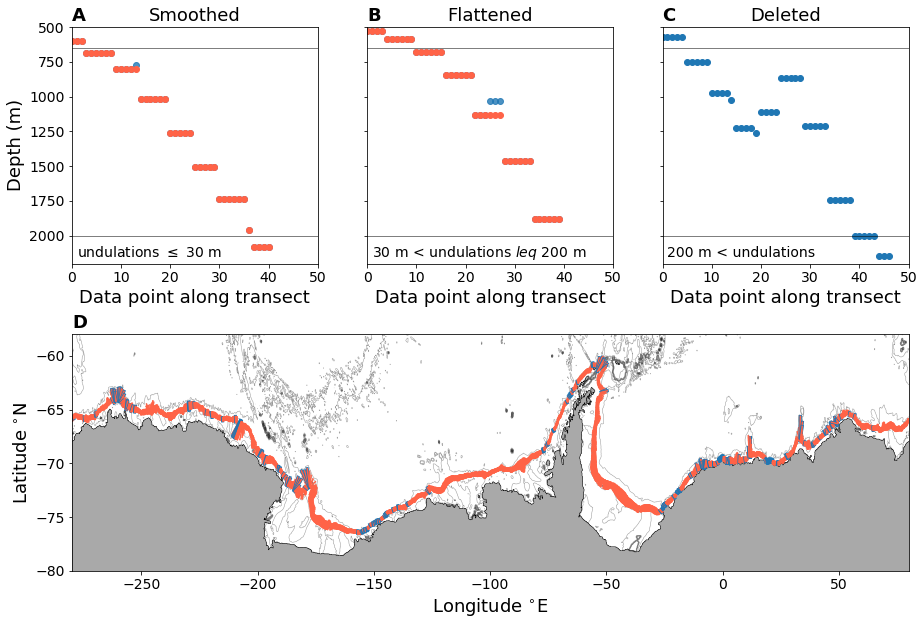

In [50]:
panel_count = 0

ft_size = 18
fig = plt.figure(figsize=(15,10))

# Define axes
gs   = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1], hspace=0.3, wspace=0.2)

for nn in range(3):
    ii = index_appendix[nn]
    hu_raw, hu_raw_orig = get_hu_transects(ii)
    panel_count += 1
    gs_n = fig.add_subplot(gs[0,panel_count-1])
    plt.title(panel_names[panel_count-1], loc='left', fontweight='bold', fontsize=ft_size)
    plt.title(panel_title[panel_count-1], fontsize=ft_size)
    plt.text(1, 2150, bump_name[panel_count-1], fontsize=ft_size-4)
    #plt.text(1, 2150, r'undulations $\leq$ 30 m', fontsize=ft_size-4)
    if ii in (index_appendix[:2]):
        plt.plot(hu_raw_orig, 'o', color='C0', alpha=0.8)
        plt.plot(hu_raw, 'o', color='tomato')
    elif ii == index_appendix[2]:
        plt.plot(hu_raw, 'o', color='C0')
    plt.ylim(2200, 500)
    plt.xlim(0, 50)
    plt.axhline( 650, color='k', linewidth=0.5)
    plt.axhline(2000, color='k', linewidth=0.5)
    #plt.yticks(np.arange(500, 2200, 500))
    plt.tick_params(labelsize=ft_size-4)
    if panel_count == 1:
        plt.ylabel('Depth (m)', fontsize=ft_size)
    plt.xlabel('Data point along transect', fontsize=ft_size)
    if panel_count > 1:
        plt.tick_params(labelleft=False)

gs_4 = fig.add_subplot(gs[1,:])
gs_4.set_title(r'$\bf{D}$', fontsize=ft_size, loc='left')
# Plot land
gs_4.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
gs_4.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
gs_4.contour(contour_1000m.xu_ocean, contour_1000m.yu_ocean, contour_1000m, [0,1], colors = '0.2', linewidth=1, alpha=0.5)
gs_4.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 1000, 2000, 3000], colors='0.2', linewidths=0.5, alpha=0.5)
gs_4.set_ylim(-80, -58)
gs_4.set_xlim(-280, 80)
# Plot transects
for ii in range(len(lon_shelf)):
    # Highlight the transects that I ignore
    if ii in (count_index_big):
        # Big bump transects
        gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3)
    if ii in (count_index_too_deep):
        # Transects with too deep first (shallowest) value
        gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='C0', linewidth=3) 
    else:
        # All transects
        gs_4.plot([lon_shelf[ii], lon_deep[ii]], [lat_shelf[ii], lat_deep[ii]], color='tomato')
gs_4.set_xlabel('Longitude $^{\circ}$E', fontsize=ft_size)
gs_4.set_ylabel('Latitude $^{\circ}$N', fontsize=ft_size)
# Fontsize of ticks
gs_4.tick_params(labelsize=ft_size-4)

# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'FigA1.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

In [30]:
print(len(count_index_big))
print(len(count_index_too_deep))
print(len(lon_shelf))
# % of profiles that are deleted because the bathymetry profile is not monotonic or continental slope not well represented (too deep first value):
print( np.round((len(count_index_big)+len(count_index_too_deep)) / len(lon_shelf), 2) )

121
126
3520
0.07


In [51]:
fig_path

'/g/data/x77/wgh581/Figures/'